In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations, population_vaccinated
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
11,983 cases (7 day average) as of Fri 25 Jun, +854.0 since Thu 24 Jun
213 hospitalised (7 day average) as of Mon 28 Jun, +9.0 since Sun 27 Jun
13 died (7 day average) as of Fri 25 Jun, +0.6 since Thu 24 Jun


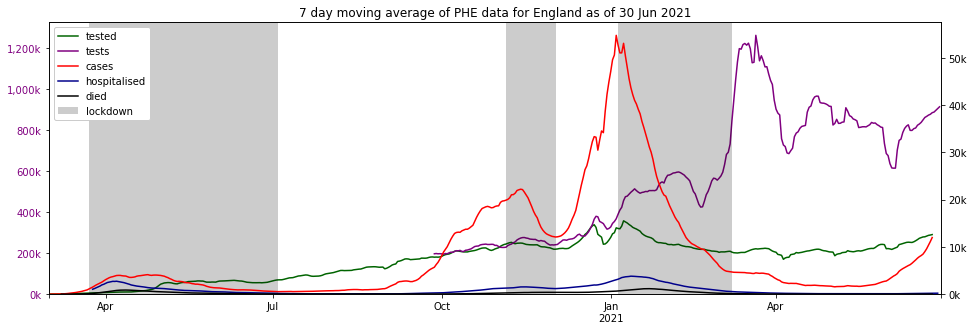

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

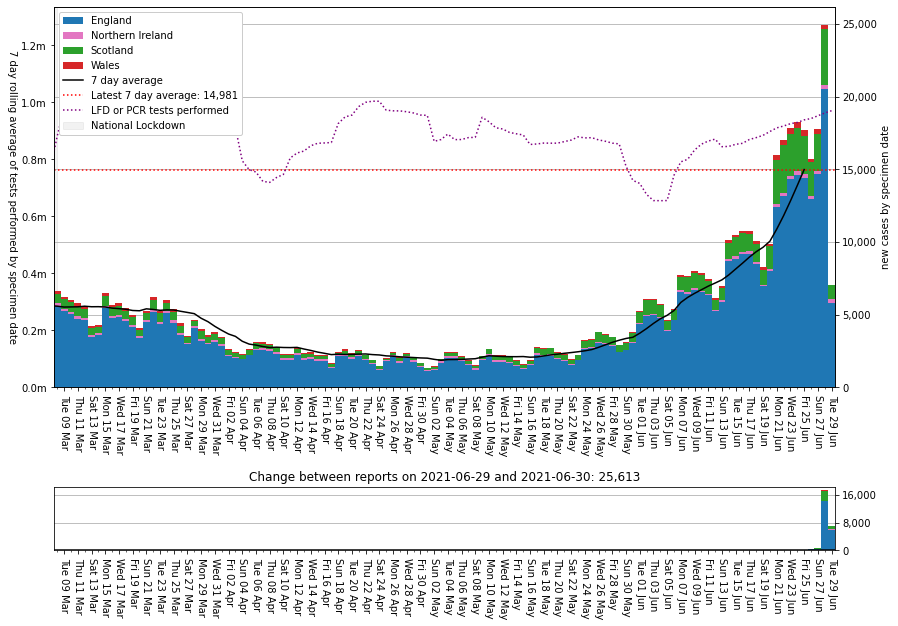

In [4]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1], date_format='%a %d %b')

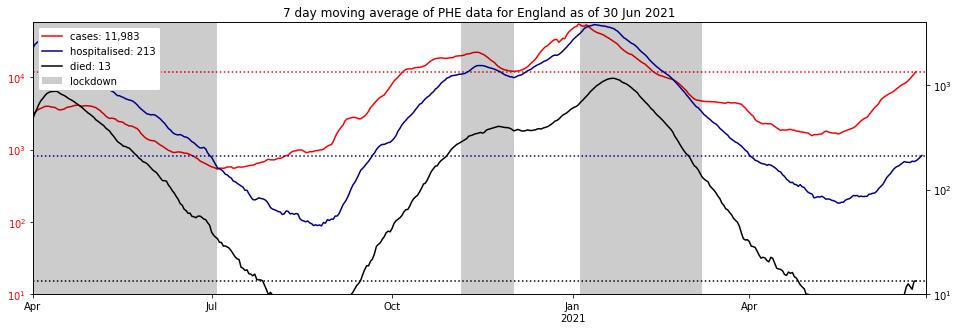

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

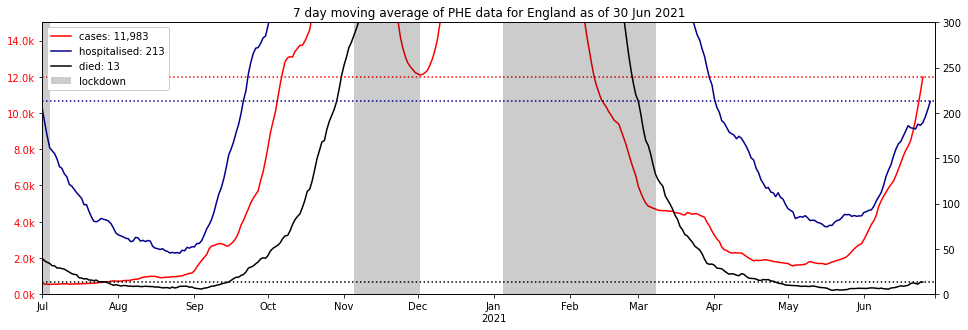

In [6]:
plot_summary(earliest_date='2020-07-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per0k_formatter, left_ymax=15_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=300)

In [7]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,29 Jun 21,"+27,637,527","+37,497,766","+27,637,527","+115,484","+115,376","+115,484"
Northern Ireland,29 Jun 21,"+862,932","+1,164,792","+862,932","+7,196","+2,337","+7,196"
Scotland,29 Jun 21,"+2,712,237","+3,799,467","+2,712,237","+11,042","+17,580","+11,042"
Wales,29 Jun 21,"+1,659,754","+2,257,737","+1,659,754","+16,966","+2,698","+16,966"


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,27637527.0,37497766.0,9860239.0,56286961,49.101118,17.517803,33.381079
1,Northern Ireland,N92000002,862932.0,1164792.0,301860.0,1893667,45.569364,15.940501,38.490136
2,Scotland,S92000003,2712237.0,3799467.0,1087230.0,5463300,49.644665,19.900610,30.454725
3,Wales,W92000004,1659754.0,2257737.0,597983.0,3152879,52.642490,18.966253,28.391258


'partial: 44,719,762 (66.9%), full: 32,872,450'

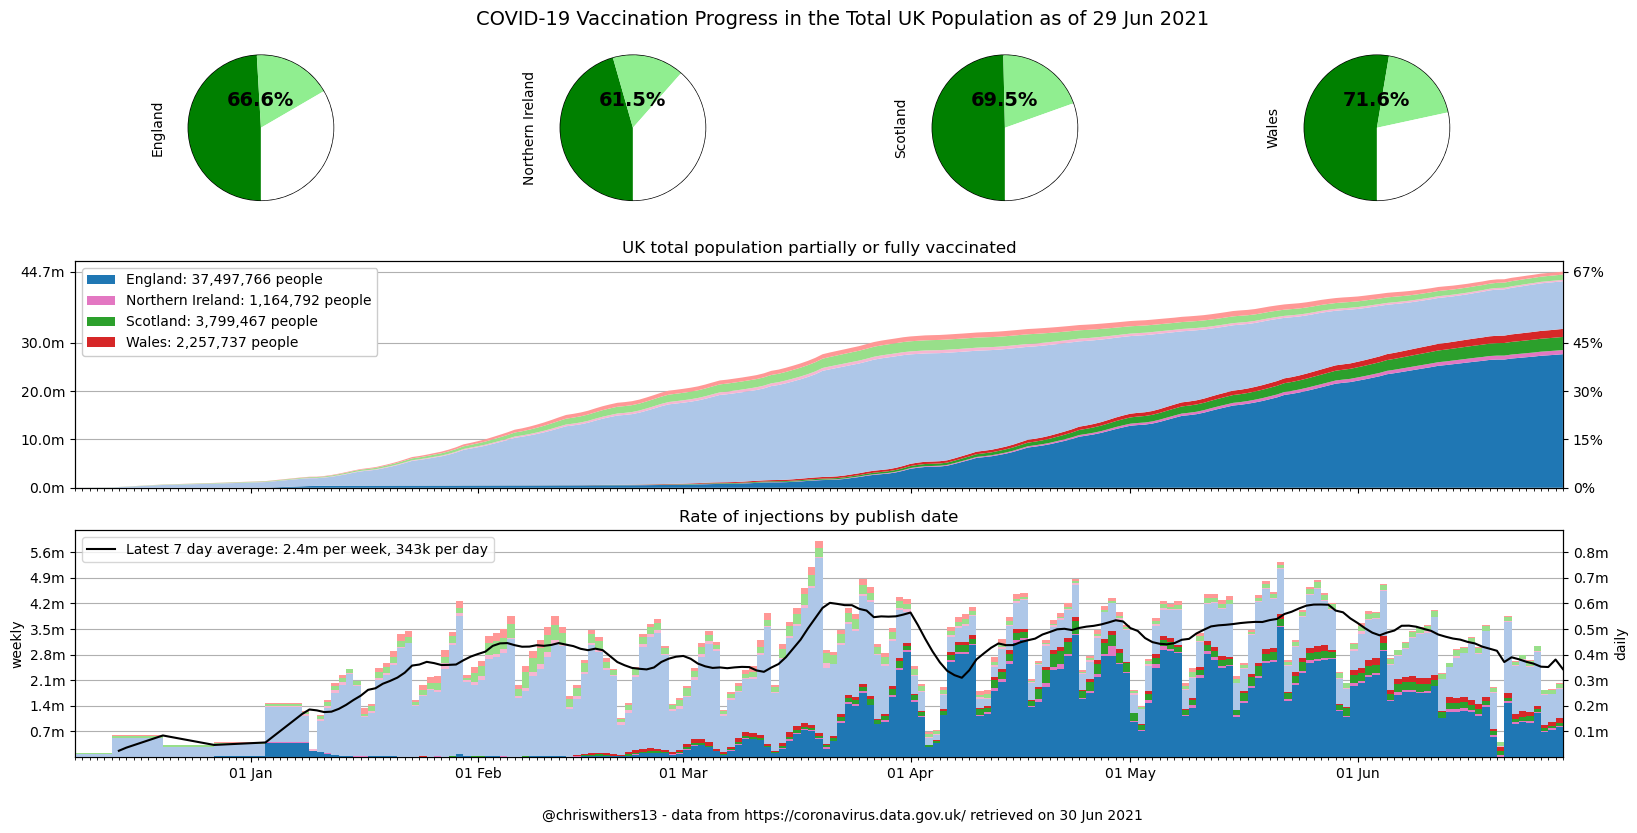

In [8]:
results = vaccination_dashboard()
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

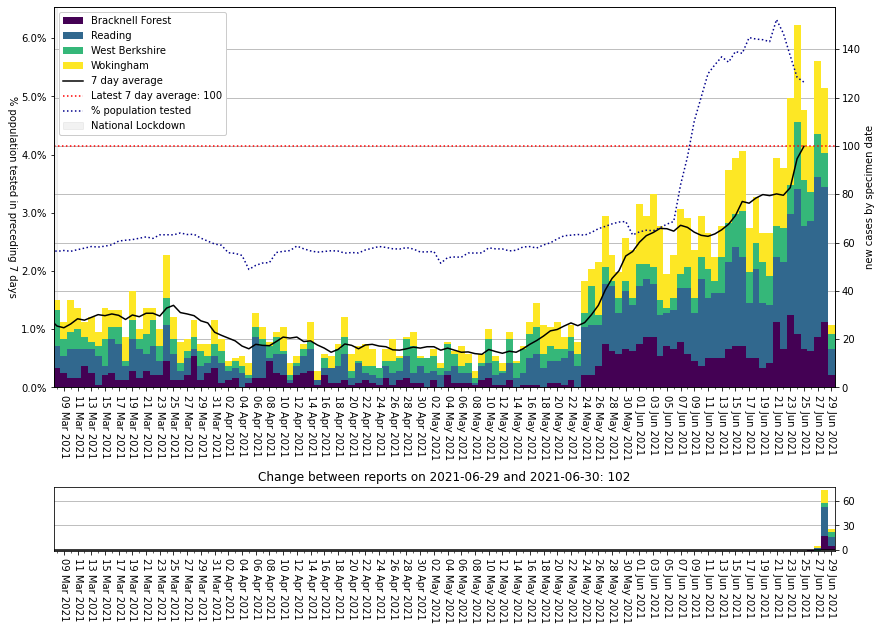

In [9]:
plot_areas(for_date, areas=my_areas, earliest=lockdown3[1], lines=unique_people_tested)

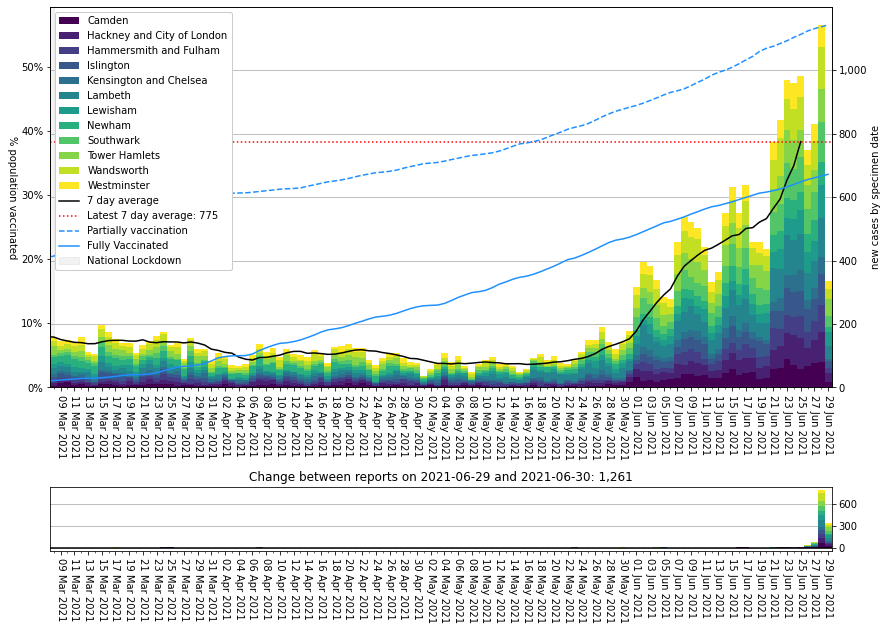

In [10]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1], lines=population_vaccinated)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
S12000042,Dundee City,695.151353,1038.0,2021-06-29
S12000019,Midlothian,559.160718,517.0,2021-06-29
E08000021,Newcastle upon Tyne,529.357374,1603.0,2021-06-29
S12000010,East Lothian,522.924643,560.0,2021-06-29
E07000199,Tamworth,499.374152,383.0,2021-06-29
E07000120,Hyndburn,498.500796,404.0,2021-06-29
S12000036,City of Edinburgh,497.780656,2613.0,2021-06-29
E07000125,Rossendale,479.841079,343.0,2021-06-29
S12000038,Renfrewshire,459.519821,823.0,2021-06-29


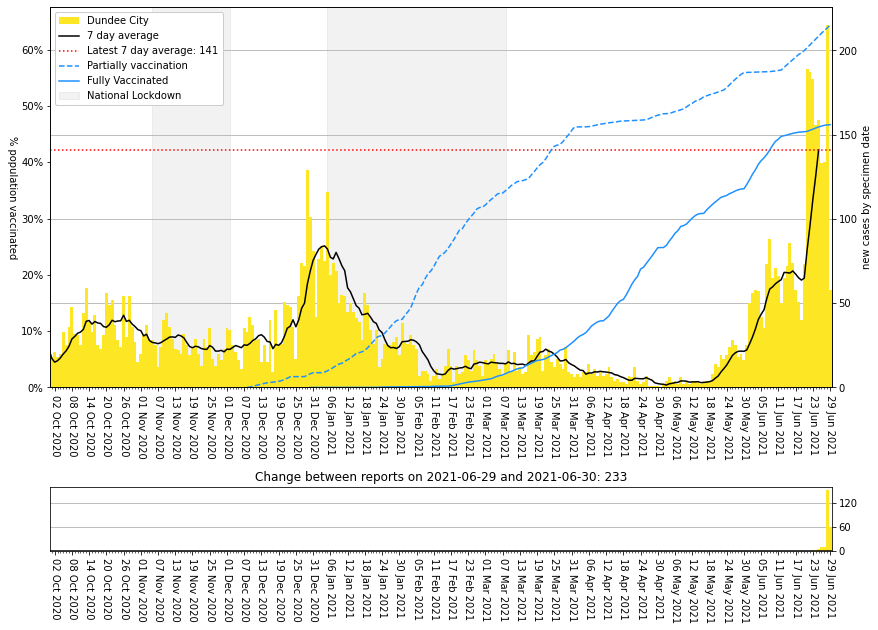

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=population_vaccinated)

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000035,Leeds,337.015328,2673.0,2021-06-29
S12000036,City of Edinburgh,497.780656,2613.0,2021-06-29
E08000025,Birmingham,207.739250,2372.0,2021-06-29
E08000003,Manchester,426.510967,2358.0,2021-06-29
E06000047,County Durham,440.299268,2334.0,2021-06-29
S12000049,Glasgow City,366.281274,2319.0,2021-06-29
E08000012,Liverpool,364.427097,1815.0,2021-06-29
E08000021,Newcastle upon Tyne,529.357374,1603.0,2021-06-29
E08000010,Wigan,414.103243,1361.0,2021-06-29


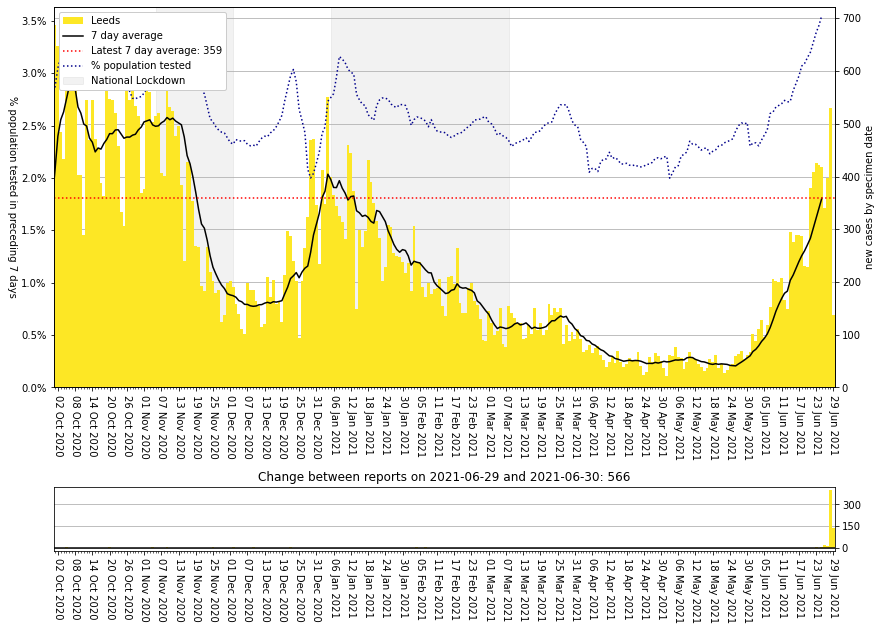

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 2.5
phe_max = 0.7

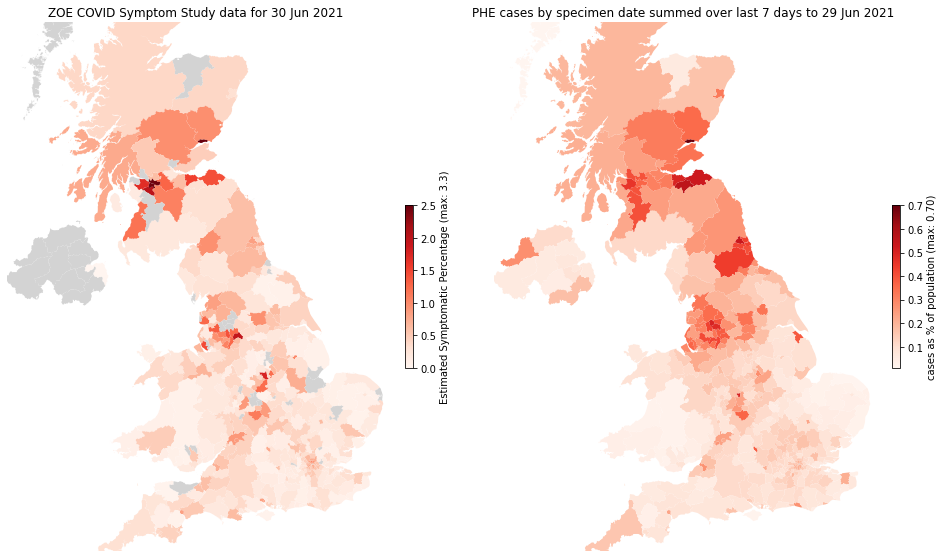

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...